In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import renderers
import sdf
import csg

In [2]:
device = torch.device("cuda")

In [3]:
def compute_rotation_matrix(axes, angles):
    nx, ny, nz = torch.unbind(axes, dim=-1)
    c, s = torch.cos(angles), torch.sin(angles)
    rotation_matrices = torch.stack([
        torch.stack([nx * nx * (1.0 - c) + 1. * c, ny * nx * (1.0 - c) - nz * s, nz * nx * (1.0 - c) + ny * s], dim=-1),
        torch.stack([nx * ny * (1.0 - c) + nz * s, ny * ny * (1.0 - c) + 1. * c, nz * ny * (1.0 - c) - nx * s], dim=-1),
        torch.stack([nx * nz * (1.0 - c) - ny * s, ny * nz * (1.0 - c) + nx * s, nz * nz * (1.0 - c) + 1. * c], dim=-1),
    ], dim=-2)
    return rotation_matrices

def render(signed_distance_function):
    
    # ---------------- camera matrix ---------------- #

    fx = fy = 1024
    cx = cy = 512
    camera_matrix = torch.tensor([[fx, 0.0, cx], [0.0, fy, cy], [0.0, 0.0, 1.0]], device=device).float()

    # ---------------- camera position ---------------- #

    distance = 5.0
    azimuth = np.pi / 4.0
    elevation = np.pi / 4.0

    camera_position = torch.tensor([
        +np.cos(elevation) * np.sin(azimuth), 
        -np.sin(elevation), 
        -np.cos(elevation) * np.cos(azimuth)
    ], device=device).float() * distance

    # ---------------- camera rotation ---------------- #

    target_position = torch.tensor([0.0, -1.0, 0.0], device=device).float()
    up_direction = torch.tensor([0.0, 1.0, 0.0], device=device).float()

    camera_z_axis = target_position - camera_position
    camera_x_axis = torch.cross(up_direction, camera_z_axis, dim=-1)
    camera_y_axis = torch.cross(camera_z_axis, camera_x_axis, dim=-1)
    camera_rotation = torch.stack((camera_x_axis, camera_y_axis, camera_z_axis), dim=-1)
    camera_rotation = nn.functional.normalize(camera_rotation, dim=-2)

    # ---------------- directional light ---------------- #

    light_directions = torch.tensor([1.0, -0.5, 0.0], device=device)

    # ---------------- ray marching ---------------- #

    y_positions = torch.arange(cy * 2, dtype=camera_matrix.dtype, device=device).float()
    x_positions = torch.arange(cx * 2, dtype=camera_matrix.dtype, device=device).float()
    y_positions, x_positions = torch.meshgrid(y_positions, x_positions, indexing='ij')
    z_positions = torch.ones_like(y_positions).float()
    ray_positions = torch.stack((x_positions, y_positions, z_positions), dim=-1)
    ray_positions = torch.einsum("mn,...n->...m", torch.inverse(camera_matrix),  ray_positions)
    ray_positions = torch.einsum("mn,...n->...m", camera_rotation, ray_positions) + camera_position
    ray_directions = nn.functional.normalize(ray_positions - camera_position, dim=-1)
   
    # ---------------- rendering ---------------- #

    ground = sdf.plane(torch.tensor([0.0, -1.0, 0.0], device=device), 0.0)
        
    num_iterations = 2000
    convergence_threshold = 1e-3

    signed_distance_function = csg.union(signed_distance_function, ground)

    surface_positions, converged = renderers.sphere_tracing(
        signed_distance_function=signed_distance_function, 
        ray_positions=ray_positions, 
        ray_directions=ray_directions, 
        num_iterations=num_iterations, 
        convergence_threshold=convergence_threshold,
    )
    surface_positions = torch.where(converged, surface_positions, torch.zeros_like(surface_positions))

    surface_normals = renderers.compute_normal(
        signed_distance_function=signed_distance_function, 
        surface_positions=surface_positions,
    )
    surface_normals = torch.where(converged, surface_normals, torch.zeros_like(surface_normals))

    image = renderers.phong_shading(
        surface_normals=surface_normals, 
        view_directions=camera_position - surface_positions, 
        light_directions=light_directions, 
        light_ambient_color=torch.ones(1, 1, 3, device=device),
        light_diffuse_color=torch.ones(1, 1, 3, device=device), 
        light_specular_color=torch.ones(1, 1, 3, device=device), 
        material_ambient_color=torch.full((1, 1, 3), 0.2, device=device) + (torch.rand(1, 1, 3, device=device) * 2 - 1) * 0.1,
        material_diffuse_color=torch.full((1, 1, 3), 0.7, device=device) + (torch.rand(1, 1, 3, device=device) * 2 - 1) * 0.1,
        material_specular_color=torch.full((1, 1, 3), 0.1, device=device),
        material_emission_color=torch.zeros(1, 1, 3, device=device),
        material_shininess=64.0,
    )

    grounded = torch.abs(ground(surface_positions)) < convergence_threshold
    image = torch.where(grounded, torch.full_like(image, 0.9), image)

    shadowed = renderers.compute_shadows(
        signed_distance_function=signed_distance_function, 
        surface_positions=surface_positions, 
        surface_normals=surface_normals,
        light_directions=light_directions, 
        num_iterations=num_iterations, 
        convergence_threshold=convergence_threshold,
        foreground_masks=converged,
    )
    image = torch.where(shadowed, image * 0.5, image)

    image = torch.where(converged, image, torch.zeros_like(image))
    
    return image

In [4]:
# ---------------- test ---------------- #


In [5]:
# Define SDF
signed_distance_functions = sdf.translation(sdf.sphere(0.5), torch.tensor([0.0, -1.0, 0.0], device=device))

In [6]:
# Evaluation Grid
x_positions = torch.tensor([1.], device=device).float()
y_positions = torch.tensor([0.], device=device).float()
z_positions = torch.tensor([0.], device=device).float()

ray_positions = torch.stack((x_positions, y_positions, z_positions), dim=-1)

In [9]:
# Evaluate
signed_distance_functions(ray_positions)

tensor([[0.9142]], device='cuda:0')

In [10]:
# Render (debug)
image = render(signed_distance_functions)

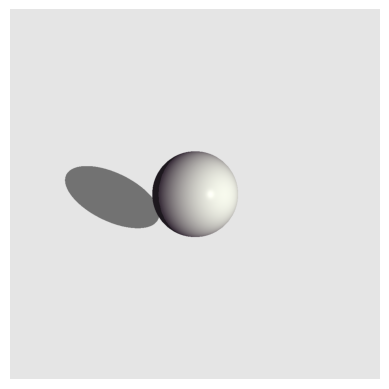

In [11]:
# Scale the tensor to the range [0, 255]
tensor = (image * 255).byte()  # Convert to byte (uint8)

# Convert to NumPy array
np_array = tensor.cpu().numpy()

# Convert to a PIL image
image = Image.fromarray(np_array)

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

In [24]:
# ---------------- load target ---------------- #
from pytorch3d.io import load_ply
from pytorch3d.structures import Meshes
import meshplot as mp

In [25]:
# Load the target mesh
verts, faces = load_ply('../data/37289.ply')

# Convert vertices to a tensor if not already
if not isinstance(verts, torch.Tensor):
    verts = torch.tensor(verts, dtype=torch.float32)

# Step 1: Compute the bounding box (min/max coordinates)
min_coords = verts.min(dim=0)[0]
max_coords = verts.max(dim=0)[0]

# Step 2: Compute the center of the bounding box
center = (min_coords + max_coords) / 2.0

# Step 3: Center the object to the origin
verts_centered = verts - center

# Step 4: Compute the scale factor to fit within the unit cube
scale_factor = 1.0 / (max_coords - min_coords).max()

# Step 5: Scale the object to fit the unit cube
verts_scaled = verts_centered * scale_factor

# Step 6: Translate the object to the first octant (shift so all coordinates are positive)
min_coords_after_scaling = verts_scaled.min(dim=0)[0]
verts_final = verts_scaled - min_coords_after_scaling

# Now `mesh` is centered and scaled to fit in the first octant cube

In [27]:
mp.plot(verts_final.numpy(), faces.numpy())


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5, 0.47…